In [1]:
!pip install timm
!pip install lightning
!pip install astropy
import torch
import torch.nn as nn
import timm
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm


import sys
sys.path.append('/content/')

from dataloader_fits import SunImageDataset

from lightning.fabric import Fabric

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd

import scipy.stats as stats

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import zipfile

zip_path = '/content/drive/MyDrive/Dataset/aia_synoptic_copy_1.zip'
extract_path = '/content/'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [2]:
# Hyper-parameters
input_size = 224*224
hidden_size = 166
# hidden_size = 1024
num_epochs = 10
batch_size = 2
learning_rate = 0.001
dropout = 0.5
lstm_layers = 2

k_folds = 5

In [3]:
import random
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

set_seed(42)

In [6]:
dataset = SunImageDataset(csv_file="/content/dataset_full_2024_with_cr_5days.csv", offset=0)

total_size = len(dataset)
fold_size = total_size // k_folds
indices = list(range(total_size))

k_fold_1_indices = indices[:fold_size-24]
k_fold_2_indices = indices[fold_size+24:(2*fold_size)-24]
k_fold_3_indices = indices[(2*fold_size)+24:(3*fold_size)-24]
k_fold_4_indices = indices[(3*fold_size)+24:(4*fold_size)-24]
k_fold_5_indices = indices[(4*fold_size)+24:]

print(len(k_fold_1_indices))
print(len(k_fold_2_indices))
print(len(k_fold_3_indices))
print(len(k_fold_4_indices))
print(len(k_fold_5_indices))

dataloaders = [k_fold_1_indices, k_fold_2_indices, k_fold_3_indices, k_fold_4_indices, k_fold_5_indices]

# Get date list
kp_dates = pd.read_csv("/content/matched_kp_dates_full_2024_with_cr_5days.csv")
kp_dates_list = kp_dates["date"].tolist()

1869
1845
1845
1845
1872


In [7]:
# Get active indices
dataset_csv_file = pd.read_csv("/content/dataset_full_2024_with_cr_5days.csv")
active_indices = []

for i in dataset_csv_file.index:
    if dataset_csv_file['Kp'][i] >= 3.667:
        active_indices.append(i)

active_dataloaders = []
for dataloader in dataloaders:
    active_dataloaders.append(list(set(dataloader) & set(active_indices)))

for dataloader in active_dataloaders:
    print(len(dataloader))

412
620
524
291
679


In [8]:

class GmiSwinTransformer(nn.Module):
    def __init__(self, hidden_size: int):
        super(GmiSwinTransformer, self).__init__()

        # Batch normalization for 3 channels
        self.bn = nn.BatchNorm2d(3)

        # Initialize Swin Transformer
        self.pretrained_model = timm.create_model(
            'swin_base_patch4_window7_224',
            pretrained=True,
            num_classes=hidden_size
        )


        self.lstm = nn.LSTM(hidden_size, hidden_size * 2, lstm_layers, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.LeakyReLU(),
            nn.Dropout(p=dropout),
            nn.Linear(hidden_size*2, hidden_size),
            nn.Dropout(p=dropout),  # Added dropout probability
            nn.LeakyReLU(),
            nn.Linear(hidden_size, 1),
            # nn.LeakyReLU()

        )

    def forward(self, images) -> torch.Tensor:
        """
        Batch should be in format:
        {
            'images': torch.FloatTensor((10, 1, 224, 224))
        }
        """

        batch_size = images.shape[0]

        images = images.reshape(-1, 1, 224, 224)
        images = torch.cat([images, images, images], dim=1)
        normalized_images = self.bn(images)
        features = self.pretrained_model(normalized_images)
        image_features = features.view(batch_size, 10, -1)

        # hidden_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # cell_states = torch.zeros(lstm_layers, image_features.size(0), hidden_size * 2)
        # image_features, _ = self.lstm(image_features, (hidden_states, cell_states))
        image_features, _ = self.lstm(image_features)

        image_features = image_features[:, -1, :]
        output = self.fc(image_features)
        return output

# Initialize model
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = GmiSwinTransformer(hidden_size=hidden_size).to(device)
model = GmiSwinTransformer(hidden_size=hidden_size)

# print(torchsummary.summary(model, (10, 1, 224, 224)))

# Loss and optimizer
criterion = nn.MSELoss()

In [9]:
torch.cuda.empty_cache()

In [10]:
def calculate_rates(all_outputs, all_labels):
    storm_labels = []
    for output in all_labels:
        if output < 3.667:
            storm_labels.append(0)
        else:
            storm_labels.append(1)
    storm_outputs = []
    for output in all_outputs:
        if output < 3.667:
            storm_outputs.append(0)
        else:
            storm_outputs.append(1)

    # Calculate true positive, true negative, false positive, false negative
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    for i in range(len(storm_labels)):
        if storm_labels[i] == 1 and storm_outputs[i] == 1:
            tp += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 0:
            tn += 1
        elif storm_labels[i] == 0 and storm_outputs[i] == 1:
            fp += 1
        elif storm_labels[i] == 1 and storm_outputs[i] == 0:
            fn += 1

    return tp, tn, fp, fn


def true_skill_score(tp, tn, fp, fn):

    # Calculate true skill score
    tss = (tp / (tp + fp)) - (fp / (fp + tn)) if ((tp > 0 and tn > 0) or fp > 0) else 0
    return tss

def calculate_metrics(tp, tn, fp, fn):
    # Calculate accuracy
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0

    # Calculate precision
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0

    # Calculate recall
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # Calculate F1 score
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return accuracy, precision, recall, f1





In [11]:
def train_model(fabric):
  print(fabric.device)
  total_avg_test_loss = 0
  total_rmse = 0
  total_mse = 0
  total_mae = 0
  total_r2 = 0
  total_r = 0
  total_tts = 0
  total_accuracy = 0
  total_precision = 0
  total_recall = 0
  total_f1 = 0

  active_total_avg_test_loss = 0
  active_total_rmse = 0
  active_total_mse = 0
  active_total_mae = 0
  active_total_r2 = 0
  active_total_r = 0


  for i in range(k_folds):
      print(f'FOLD {i + 1}')
      print('--------------------------------')
      test_indices = dataloaders[i]
      active_test_indices = active_dataloaders[i]
      train_indices = []
      for j in range(k_folds):
          if j != i:
              train_indices += dataloaders[j]

      trainloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, train_indices), batch_size=batch_size, shuffle=True, num_workers=20, prefetch_factor=6, pin_memory=True, worker_init_fn=lambda _: np.random.seed(42))
      testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      active_testloader = torch.utils.data.DataLoader(dataset=torch.utils.data.Subset(dataset, active_test_indices), batch_size=batch_size, shuffle=False, num_workers=20, prefetch_factor=6, pin_memory=True)
      trainloader = fabric.setup_dataloaders(trainloader)
      testloader = fabric.setup_dataloaders(testloader)
      active_testloader = fabric.setup_dataloaders(active_testloader)


      # Reinitialize model
      model = GmiSwinTransformer(hidden_size=hidden_size)
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
      model, optimizer = fabric.setup(model, optimizer)
      model.train()

      # Training the model
      n_total_steps = len(trainloader)
      avg_train_loss_over_epochs = []
      avg_val_loss_over_epochs = []

      for epoch in range(num_epochs):
          train_losses = []
          val_losses = []

          # Training loop
          model.train()
          for i, (images, labels) in tqdm(enumerate(trainloader), desc=f"Training Progress: Epoch: {epoch + 1}", total=len(trainloader)):
              # Move images and labels to device
              images = images.float()
              labels = labels.float()

              # Forward pass with autograd
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              # tqdm.write(f"Epoch: {epoch+1}, Index: {i}, Loss: {loss.item():.4f}")

              # Backward pass and optimization
              optimizer.zero_grad()
              fabric.backward(loss)
              optimizer.step()
              # Store the loss
              train_losses.append(loss.item())

          # Store the average training loss for this epoch
          avg_train_loss_over_epochs.append(sum(train_losses) / len(train_losses))
          print("Average Training Loss: ", sum(train_losses) / len(train_losses))

          # Validation loop
          model.eval()
          with torch.no_grad():
              for images, labels in tqdm(testloader, desc=f"Validation Progress: Epoch: {epoch + 1}", total=len(testloader)):
                  images = images.float()
                  # images = images.permute(1, 0, 2, 3, 4)
                  labels = labels.float()
                  outputs = model(images).squeeze(1)
                  loss = criterion(outputs, labels)
                  # print("Validation Loss: ", loss.item())
                  val_losses.append(loss.item())

          # Store the average validation loss for this epoch
          avg_val_loss_over_epochs.append(sum(val_losses) / len(val_losses))
          print("Average Validation Loss: ", sum(val_losses) / len(val_losses))

      # Plot loss over epochs
      plt.figure()
      plt.plot(range(1, num_epochs + 1), avg_train_loss_over_epochs, label='Average Training Loss', marker='o')
      plt.plot(range(1, num_epochs + 1), avg_val_loss_over_epochs, label='Average Validation Loss', marker='o')
      plt.xticks(range(1, num_epochs + 1))  # Ensure x-axis includes all epoch numbers
      plt.xlabel('Epoch')
      plt.ylabel('Average Loss')
      plt.legend()
      plt.title('Training and Validation Loss Over Epochs')
      plt.show()

      test_losses = []
      all_labels = []
      all_outputs = []

      model.eval()

      print('--------------------------------')
      print('Test for Full set')
      print('--------------------------------')

  # Test for Full set
      with torch.no_grad():
          for images, labels in tqdm(testloader, desc="Testing Progress"):
              images = images.float()
              # images = images.permute(1, 0, 2, 3, 4)
              labels = labels.float()
              # print("Label: ", labels)
              outputs = model(images).squeeze(1)
              # print("Output: ", outputs)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)
      tp, tn, fp, fn = calculate_rates(all_outputs, all_labels)
      accuracy, precision, recall, f1 = calculate_metrics(tp, tn, fp, fn)
      tts = true_skill_score(tp, tn, fp, fn)



      # Accumulate metrics for averaging across folds
      total_avg_test_loss += avg_test_loss
      total_rmse += rmse
      total_mse += mse
      total_mae += mae
      total_r2 += r2
      total_r += r
      total_tts += tts
      total_accuracy += accuracy
      total_precision += precision
      total_recall += recall
      total_f1 += f1


      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      print(f'True Skill Score: {tts:.4f}')
      print(f'Accuracy: {accuracy:.4f}')
      print(f'Precision: {precision:.4f}')
      print(f'Recall: {recall:.4f}')
      print(f'F1 Score: {f1:.4f}')

      test_dates = list(kp_dates_list[i] for i in test_indices)
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')
      plt.plot([0, len(test_dates)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')
      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Format x-axis with dates
      test_dates_sliced = test_dates[0:len(all_labels):20]
      plt.xticks(range(0, len(test_dates), 20), test_dates_sliced, rotation=30, ha='right')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Date', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)

      print('--------------------------------')
      print('Test for Active Periods')
      print('--------------------------------')

      test_losses = []
      all_labels = []
      all_outputs = []

  # Test for active periods
      with torch.no_grad():
          for images, labels in tqdm(active_testloader, desc="Testing Progress"):
              images = images.float()
              labels = labels.float()
              outputs = model(images).squeeze(1)
              loss = criterion(outputs, labels)
              test_losses.append(loss.item())
              all_labels.extend(labels.cpu().numpy())
              all_outputs.extend(outputs.cpu().numpy())

      avg_test_loss = sum(test_losses) / len(test_losses)
      rmse = math.sqrt(avg_test_loss)
      mse = mean_squared_error(all_labels, all_outputs)
      mae = mean_absolute_error(all_labels, all_outputs)
      r2 = r2_score(all_labels, all_outputs)
      r, _ = stats.pearsonr(all_labels, all_outputs)



      # Accumulate metrics for averaging across folds
      active_total_avg_test_loss += avg_test_loss
      active_total_rmse += rmse
      active_total_mse += mse
      active_total_mae += mae
      active_total_r2 += r2
      active_total_r += r




      print(f'Average test loss: {avg_test_loss:.4f}')
      print(f'RMSE: {rmse:.4f}')
      print(f'MSE: {mse:.4f}')
      print(f'MAE: {mae:.4f}')
      print(f'R²: {r2:.4f}')
      print(f'R: {r:.4f}')
      # Convert to pandas Series for easy rolling average calculation
      labels_series = pd.Series(all_labels)
      outputs_series = pd.Series(all_outputs)

      # Calculate rolling averages with a window size of 5
      window_size = 2
      labels_rolling = labels_series.rolling(window=window_size, center=True).mean()
      outputs_rolling = outputs_series.rolling(window=window_size, center=True).mean()

      # Create a better-looking plot
      plt.figure(figsize=(50, 6), facecolor='#f8f9fa')

      plt.plot([0, len(all_labels)], [3.667, 3.667], 'r--', alpha=0.6, label='Kp = 4-')

      # Plot original data with thin lines
      plt.plot(all_labels, '-', color='#1f77b4', linewidth=1, alpha=0.6, label='Actual Labels')
      plt.plot(all_outputs, '--', color='#ff7f0e', linewidth=1, alpha=0.6, label='Predicted Labels')

      # Plot smoothed data with thicker lines
      plt.plot(labels_rolling, '-', color='#2c5282', linewidth=2.5, label='Actual Labels (Smoothed)')
      plt.plot(outputs_rolling, '--', color='#c05621', linewidth=2.5, label='Predicted Labels (Smoothed)')

      # Better grid styling
      plt.grid(True, linestyle='--', alpha=0.7)

      # Improve labels and title
      plt.xlabel('Sample Index', fontsize=12)
      plt.ylabel('KP Index', fontsize=12)
      plt.title('Comparison of Actual vs Predicted KP Index Values', fontsize=14)

      # Better legend
      plt.legend(loc='best', frameon=True, fontsize=12)

      # Adjust layout for better spacing
      plt.tight_layout()

      plt.show()
      print(all_outputs)


  print('--------------------------------')
  print('Metrics for Full Set')
  print('--------------------------------')

  # Average metrics across all folds
  total_avg_test_loss /= k_folds
  total_rmse /= k_folds
  total_mse /= k_folds
  total_mae /= k_folds
  total_r2 /= k_folds
  total_r /= k_folds
  total_tts /= k_folds
  total_accuracy /= k_folds
  total_precision /= k_folds
  total_recall /= k_folds
  total_f1 /= k_folds

  print(f'Average test loss across all folds: {total_avg_test_loss:.4f}')
  print(f'Average RMSE across all folds: {total_rmse:.4f}')
  print(f'Average MSE across all folds: {total_mse:.4f}')
  print(f'Average MAE across all folds: {total_mae:.4f}')
  print(f'Average R² across all folds: {total_r2:.4f}')
  print(f'Average R across all folds: {total_r:.4f}')
  print(f'Average True Skill Score across all folds: {total_tts:.4f}')
  print(f'Average Accuracy across all folds: {total_accuracy:.4f}')
  print(f'Average Precision across all folds: {total_precision:.4f}')
  print(f'Average Recall across all folds: {total_recall:.4f}')
  print(f'Average F1 Score across all folds: {total_f1:.4f}')

  print('--------------------------------')
  print('Metrics for Active Periods')
  print('--------------------------------')
  # Average metrics across all folds
  active_total_avg_test_loss /= k_folds
  active_total_rmse /= k_folds
  active_total_mse /= k_folds
  active_total_mae /= k_folds
  active_total_r2 /= k_folds
  active_total_r /= k_folds

  print(f'Average active test loss across all folds: {active_total_avg_test_loss:.4f}')
  print(f'Average active RMSE across all folds: {active_total_rmse:.4f}')
  print(f'Average active MSE across all folds: {active_total_mse:.4f}')
  print(f'Average active MAE across all folds: {active_total_mae:.4f}')
  print(f'Average active R² across all folds: {active_total_r2:.4f}')
  print(f'Average active R across all folds: {active_total_r:.4f}')




INFO: Using bfloat16 Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using bfloat16 Automatic Mixed Precision (AMP)


cuda:0
FOLD 1
--------------------------------


Training Progress: Epoch: 1:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.9732255720076506


Validation Progress: Epoch: 1:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.5410112277427448


Training Progress: Epoch: 2:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.397607400347585


Validation Progress: Epoch: 2:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.9290877840540919


Training Progress: Epoch: 3:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  1.0728050040080719


Validation Progress: Epoch: 3:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.5521148654476635


Training Progress: Epoch: 4:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.8223414445007736


Validation Progress: Epoch: 4:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.7081037249628477


Training Progress: Epoch: 5:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.6313473431326375


Validation Progress: Epoch: 5:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.7665442923873285


Training Progress: Epoch: 6:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.5067991235518531


Validation Progress: Epoch: 6:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.0457783042668627


Training Progress: Epoch: 7:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.42740301604569925


Validation Progress: Epoch: 7:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.926197113043549


Training Progress: Epoch: 8:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.3690087534278712


Validation Progress: Epoch: 8:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  1.8918398166067878


Training Progress: Epoch: 9:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.30568247070392196


Validation Progress: Epoch: 9:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.1882617319746687


Training Progress: Epoch: 10:   0%|          | 0/3704 [00:00<?, ?it/s]

Average Training Loss:  0.2685983304768529


Validation Progress: Epoch: 10:   0%|          | 0/935 [00:00<?, ?it/s]

Average Validation Loss:  2.191101381702804


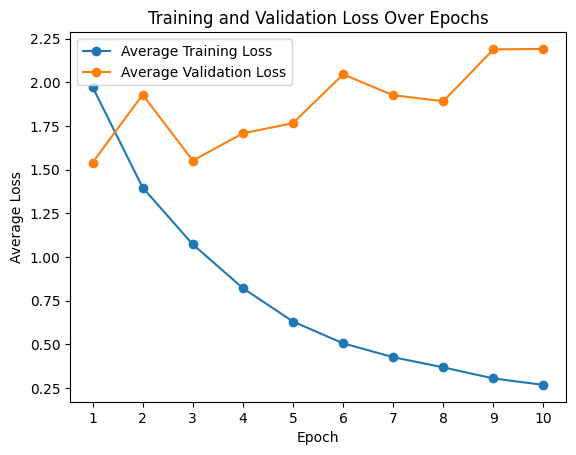

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/935 [00:00<?, ?it/s]

Average test loss: 2.1911
RMSE: 1.4802
MSE: 2.1922
MAE: 1.1822
R²: -0.4464
R: 0.2000
True Skill Score: -0.0003
Accuracy: 0.6458
Precision: 0.2852
Recall: 0.4029
F1 Score: 0.3340


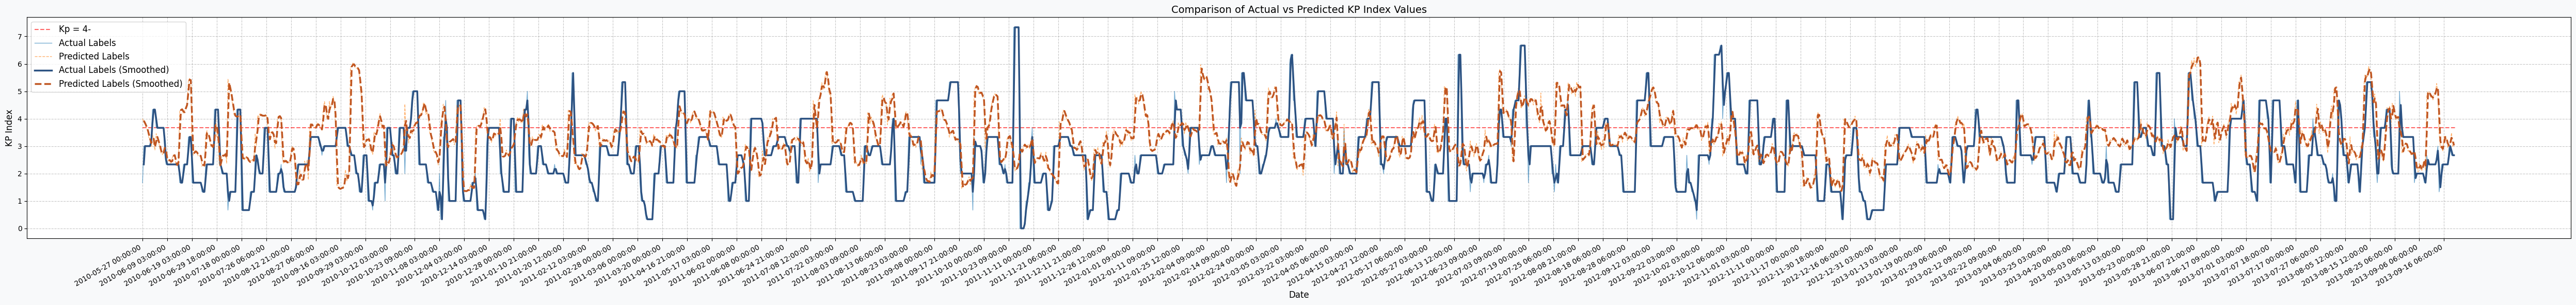

[np.float32(4.0), np.float32(3.859375), np.float32(3.828125), np.float32(3.65625), np.float32(3.59375), np.float32(3.328125), np.float32(3.25), np.float32(2.96875), np.float32(3.46875), np.float32(3.078125), np.float32(2.859375), np.float32(3.453125), np.float32(3.21875), np.float32(3.15625), np.float32(2.9375), np.float32(2.75), np.float32(2.6875), np.float32(2.828125), np.float32(3.046875), np.float32(2.59375), np.float32(2.5), np.float32(2.453125), np.float32(2.53125), np.float32(2.328125), np.float32(2.578125), np.float32(2.6875), np.float32(2.65625), np.float32(2.296875), np.float32(2.328125), np.float32(2.453125), np.float32(4.28125), np.float32(4.34375), np.float32(4.34375), np.float32(4.1875), np.float32(4.28125), np.float32(4.46875), np.float32(4.53125), np.float32(5.375), np.float32(5.46875), np.float32(5.34375), np.float32(2.796875), np.float32(2.671875), np.float32(2.84375), np.float32(2.78125), np.float32(2.765625), np.float32(2.640625), np.float32(2.640625), np.float32(2.

Testing Progress:   0%|          | 0/206 [00:00<?, ?it/s]

Average test loss: 2.2764
RMSE: 1.5088
MSE: 2.2764
MAE: 1.1762
R²: -2.6269
R: 0.0567


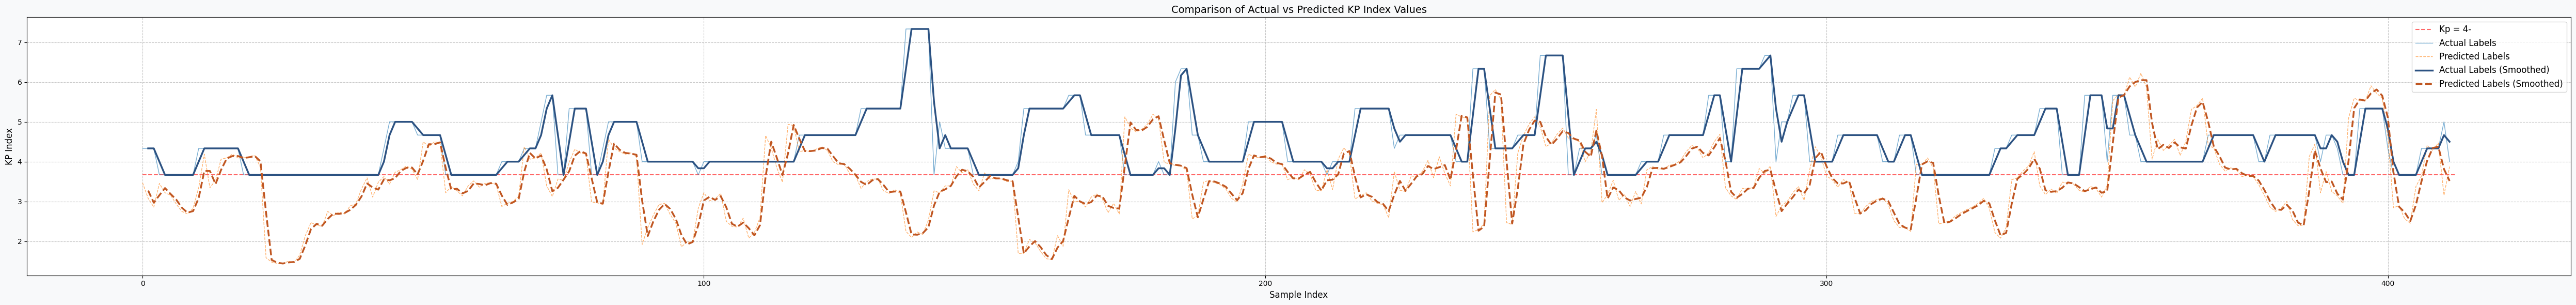

[np.float32(3.46875), np.float32(3.078125), np.float32(2.859375), np.float32(3.453125), np.float32(3.21875), np.float32(3.15625), np.float32(2.9375), np.float32(2.75), np.float32(2.6875), np.float32(2.828125), np.float32(3.34375), np.float32(4.1875), np.float32(3.34375), np.float32(3.53125), np.float32(4.0625), np.float32(4.09375), np.float32(4.1875), np.float32(4.09375), np.float32(4.09375), np.float32(4.125), np.float32(4.15625), np.float32(3.859375), np.float32(1.5859375), np.float32(1.4765625), np.float32(1.4453125), np.float32(1.4375), np.float32(1.5), np.float32(1.4609375), np.float32(1.65625), np.float32(2.140625), np.float32(2.46875), np.float32(2.40625), np.float32(2.375), np.float32(2.75), np.float32(2.640625), np.float32(2.734375), np.float32(2.6875), np.float32(2.890625), np.float32(2.9375), np.float32(3.3125), np.float32(3.59375), np.float32(3.109375), np.float32(3.484375), np.float32(3.625), np.float32(3.4375), np.float32(3.734375), np.float32(3.796875), np.float32(3.8906

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.8908453774416671


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7434946388579584


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.418313945037193


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7236045398536926


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.0770640877949298


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.928000418217497


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.7850585728458778


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.28506984431178


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5848713716561934


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9286471375146677


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4642146565928992


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9704083280386488


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3743873747556256


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  2.0724403502889794


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3291715510328086


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9666547185368912


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2789749156396676


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.8982786385304389


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.23655594520701764


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.9722270061428313


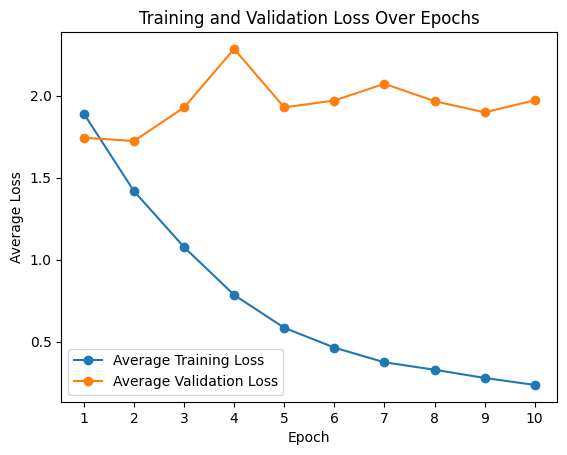

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.9722
RMSE: 1.4044
MSE: 1.9732
MAE: 1.1170
R²: -0.1449
R: 0.2063
True Skill Score: 0.2831
Accuracy: 0.6553
Precision: 0.4831
Recall: 0.3694
F1 Score: 0.4186


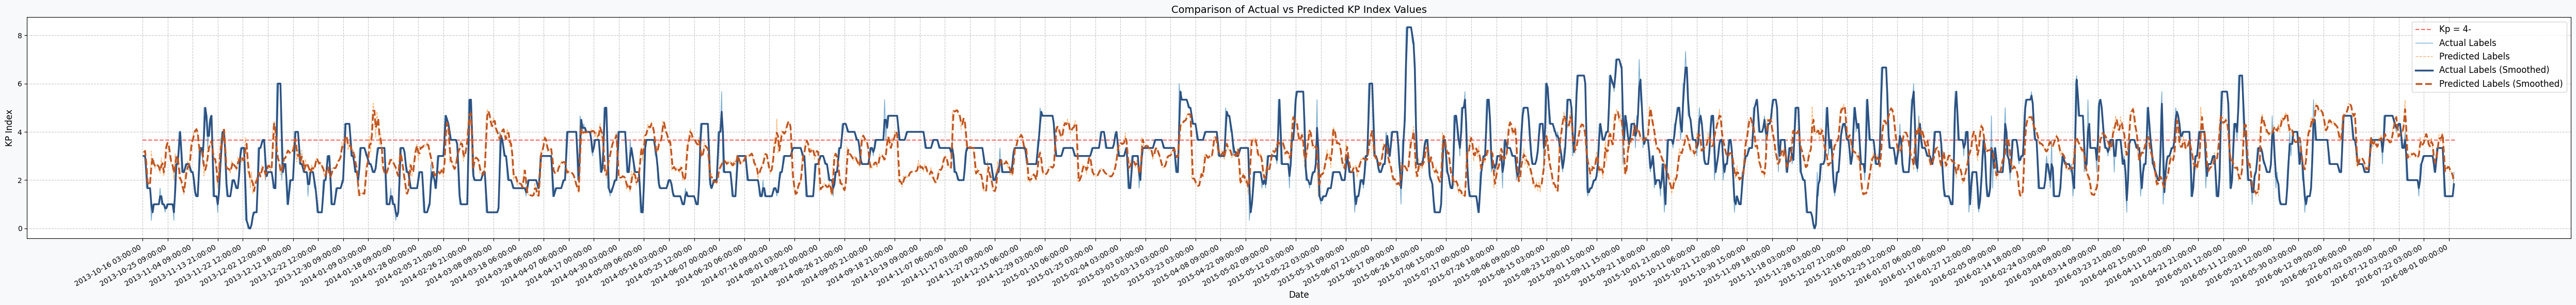

[np.float32(3.140625), np.float32(3.171875), np.float32(3.25), np.float32(2.171875), np.float32(1.7265625), np.float32(1.859375), np.float32(1.890625), np.float32(3.203125), np.float32(2.65625), np.float32(2.703125), np.float32(2.484375), np.float32(2.609375), np.float32(2.625), np.float32(2.484375), np.float32(2.28125), np.float32(2.921875), np.float32(2.46875), np.float32(2.171875), np.float32(3.21875), np.float32(3.546875), np.float32(3.546875), np.float32(3.296875), np.float32(2.796875), np.float32(2.640625), np.float32(2.59375), np.float32(2.0), np.float32(3.09375), np.float32(2.890625), np.float32(3.046875), np.float32(2.03125), np.float32(2.125), np.float32(1.8046875), np.float32(1.625), np.float32(1.3984375), np.float32(2.34375), np.float32(2.234375), np.float32(2.8125), np.float32(2.390625), np.float32(3.265625), np.float32(3.59375), np.float32(3.71875), np.float32(4.03125), np.float32(4.0625), np.float32(4.15625), np.float32(3.78125), np.float32(3.09375), np.float32(3.296875)

Testing Progress:   0%|          | 0/310 [00:00<?, ?it/s]

Average test loss: 2.6260
RMSE: 1.6205
MSE: 2.6260
MAE: 1.3165
R²: -2.3318
R: 0.1862


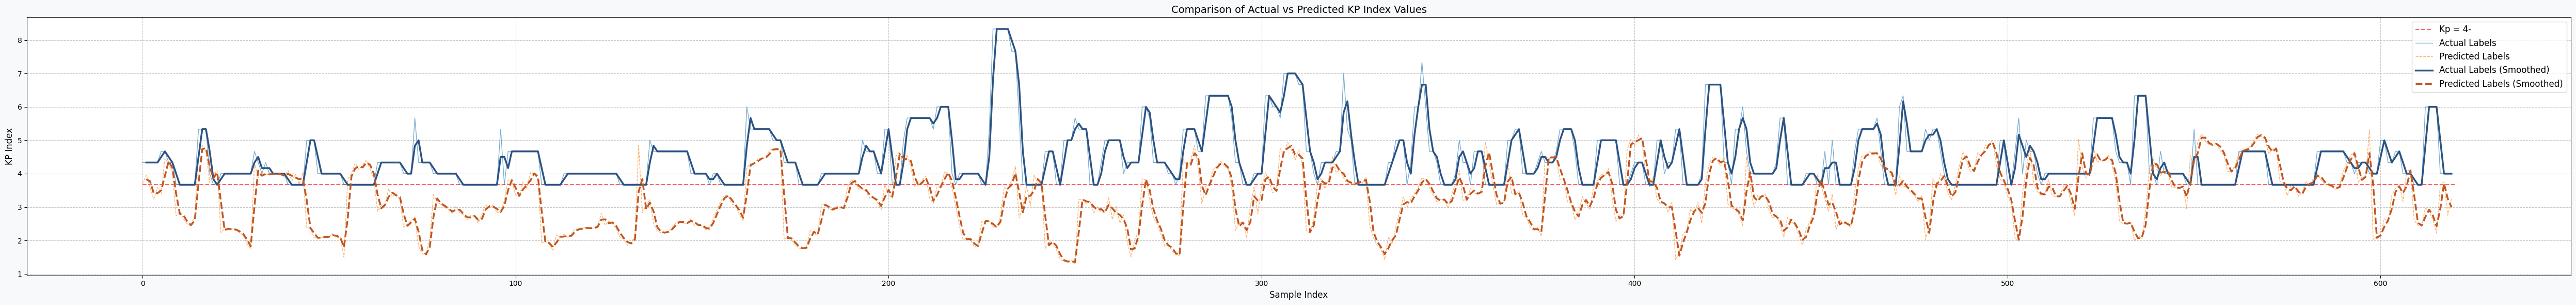

[np.float32(3.703125), np.float32(3.953125), np.float32(3.59375), np.float32(3.234375), np.float32(3.59375), np.float32(3.40625), np.float32(4.46875), np.float32(4.28125), np.float32(4.0625), np.float32(2.734375), np.float32(2.859375), np.float32(2.640625), np.float32(2.484375), np.float32(2.4375), np.float32(2.765625), np.float32(4.625), np.float32(4.84375), np.float32(4.6875), np.float32(3.734375), np.float32(3.984375), np.float32(4.09375), np.float32(2.234375), np.float32(2.390625), np.float32(2.3125), np.float32(2.34375), np.float32(2.3125), np.float32(2.234375), np.float32(2.15625), np.float32(1.8984375), np.float32(1.75), np.float32(4.3125), np.float32(3.875), np.float32(4.0), np.float32(3.984375), np.float32(3.96875), np.float32(4.0), np.float32(3.984375), np.float32(3.984375), np.float32(3.890625), np.float32(4.09375), np.float32(3.78125), np.float32(3.984375), np.float32(3.6875), np.float32(4.03125), np.float32(2.390625), np.float32(2.359375), np.float32(2.078125), np.float32(

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.8676282273271054


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5473636396904111


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.4788779225747404


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6624464746065164


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.1641397726121439


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6146902126393923


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.8878793824217358


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6435314590015644


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6478848705554741


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.521563956621477


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5192382083377554


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5700485882914865


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.41783165388640414


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6489173409096793


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.3588363878195682


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.7750149434101934


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.298377408077891


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.6377221545287717


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.26301051028049743


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5305254121165899


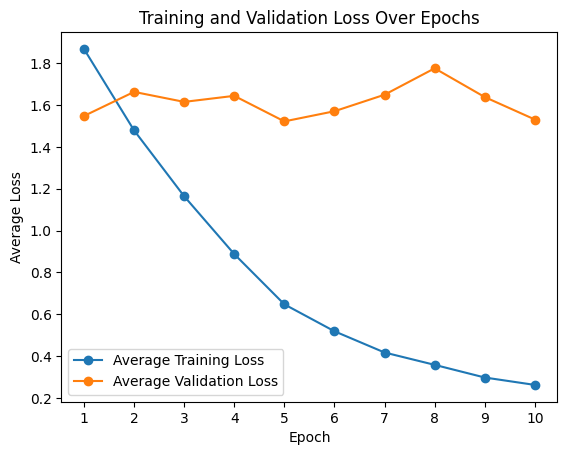

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.5305
RMSE: 1.2371
MSE: 1.5310
MAE: 0.9945
R²: 0.0935
R: 0.3672
True Skill Score: 0.4941
Accuracy: 0.7247
Precision: 0.5494
Recall: 0.1698
F1 Score: 0.2595


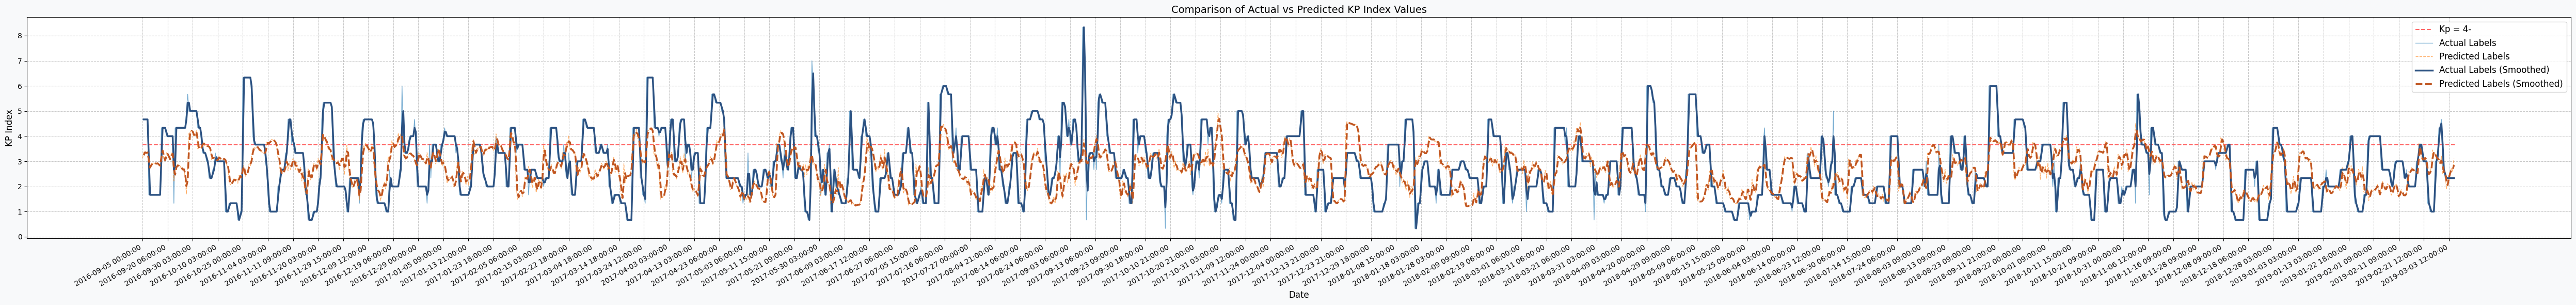

[np.float32(3.125), np.float32(3.359375), np.float32(3.359375), np.float32(3.3125), np.float32(3.390625), np.float32(2.703125), np.float32(2.796875), np.float32(2.90625), np.float32(2.90625), np.float32(2.953125), np.float32(2.890625), np.float32(2.921875), np.float32(2.921875), np.float32(2.828125), np.float32(2.828125), np.float32(3.453125), np.float32(3.40625), np.float32(3.078125), np.float32(3.015625), np.float32(3.34375), np.float32(3.25), np.float32(3.140625), np.float32(3.03125), np.float32(3.34375), np.float32(3.265625), np.float32(2.21875), np.float32(2.71875), np.float32(2.796875), np.float32(2.875), np.float32(2.78125), np.float32(2.8125), np.float32(2.703125), np.float32(2.65625), np.float32(2.71875), np.float32(2.328125), np.float32(1.703125), np.float32(2.765625), np.float32(4.15625), np.float32(4.15625), np.float32(4.25), np.float32(4.125), np.float32(3.984375), np.float32(4.125), np.float32(4.21875), np.float32(3.5), np.float32(3.53125), np.float32(3.578125), np.float3

Testing Progress:   0%|          | 0/262 [00:00<?, ?it/s]

Average test loss: 2.7992
RMSE: 1.6731
MSE: 2.7992
MAE: 1.4546
R²: -4.0620
R: 0.2881


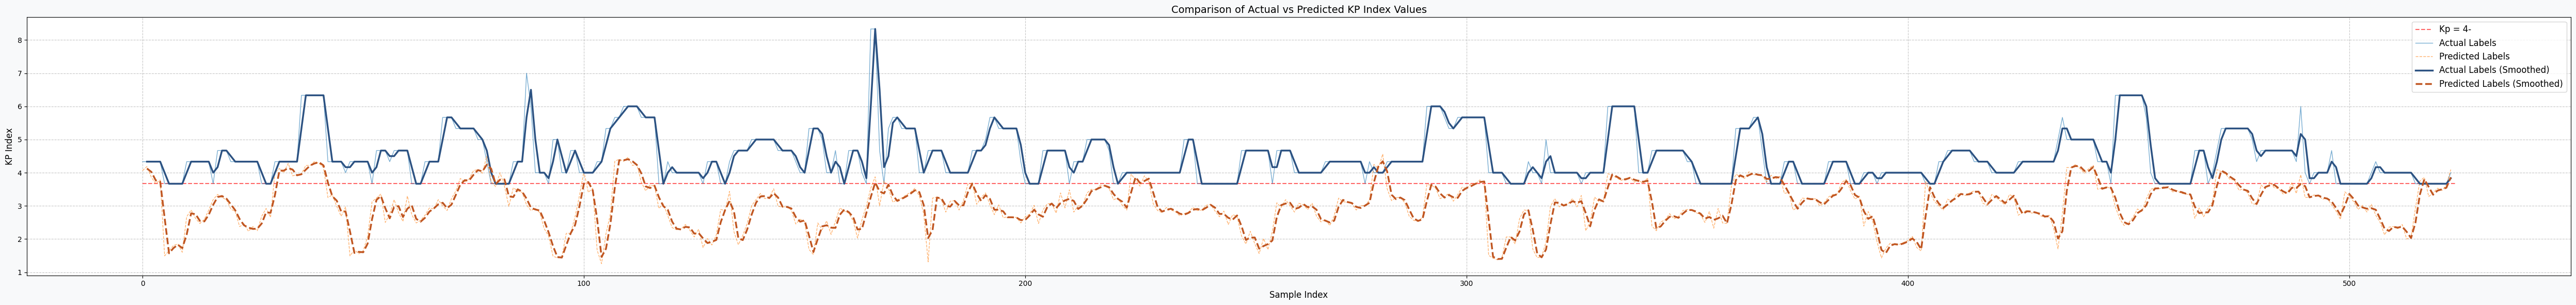

[np.float32(4.0625), np.float32(4.1875), np.float32(3.859375), np.float32(3.671875), np.float32(3.78125), np.float32(1.4921875), np.float32(1.6484375), np.float32(1.8046875), np.float32(1.8515625), np.float32(1.6015625), np.float32(2.671875), np.float32(2.875), np.float32(2.625), np.float32(2.46875), np.float32(2.59375), np.float32(2.875), np.float32(3.1875), np.float32(3.34375), np.float32(3.25), np.float32(3.1875), np.float32(2.90625), np.float32(2.828125), np.float32(2.375), np.float32(2.453125), np.float32(2.234375), np.float32(2.375), np.float32(2.25), np.float32(2.6875), np.float32(2.921875), np.float32(2.65625), np.float32(4.0), np.float32(4.125), np.float32(4.0), np.float32(4.28125), np.float32(3.90625), np.float32(3.9375), np.float32(3.96875), np.float32(4.21875), np.float32(4.21875), np.float32(4.34375), np.float32(4.28125), np.float32(4.15625), np.float32(3.25), np.float32(3.328125), np.float32(2.984375), np.float32(2.6875), np.float32(2.96875), np.float32(1.4921875), np.flo

Training Progress: Epoch: 1:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  2.0478768237655527


Validation Progress: Epoch: 1:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2373386892710503


Training Progress: Epoch: 2:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.5857391584901832


Validation Progress: Epoch: 2:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.3024273900052814


Training Progress: Epoch: 3:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  1.257431632170155


Validation Progress: Epoch: 3:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1429646997905527


Training Progress: Epoch: 4:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.9171556827276274


Validation Progress: Epoch: 4:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1798477056455159


Training Progress: Epoch: 5:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.6658624100718908


Validation Progress: Epoch: 5:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.1683701206547186


Training Progress: Epoch: 6:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.5296920051088694


Validation Progress: Epoch: 6:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.5778981247526895


Training Progress: Epoch: 7:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.4109299796322922


Validation Progress: Epoch: 7:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.170527192596235


Training Progress: Epoch: 8:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.34575788976301425


Validation Progress: Epoch: 8:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2877907334535108


Training Progress: Epoch: 9:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.29089746840117625


Validation Progress: Epoch: 9:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.2706553578606565


Training Progress: Epoch: 10:   0%|          | 0/3716 [00:00<?, ?it/s]

Average Training Loss:  0.2508580899693972


Validation Progress: Epoch: 10:   0%|          | 0/923 [00:00<?, ?it/s]

Average Validation Loss:  1.4658919616021246


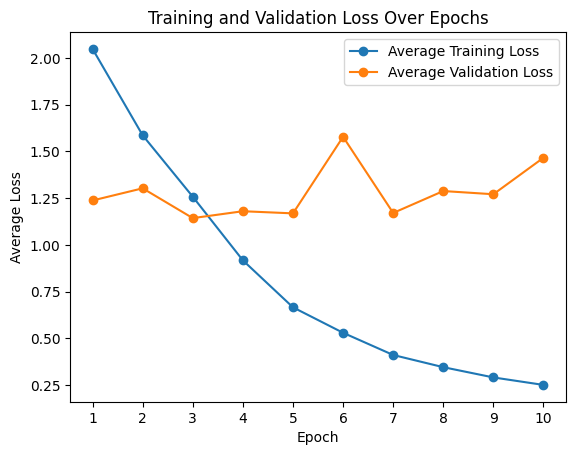

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/923 [00:00<?, ?it/s]

Average test loss: 1.4659
RMSE: 1.2107
MSE: 1.4664
MAE: 0.9197
R²: -0.1269
R: 0.4118
True Skill Score: 0.6602
Accuracy: 0.8477
Precision: 0.6667
Recall: 0.0687
F1 Score: 0.1246


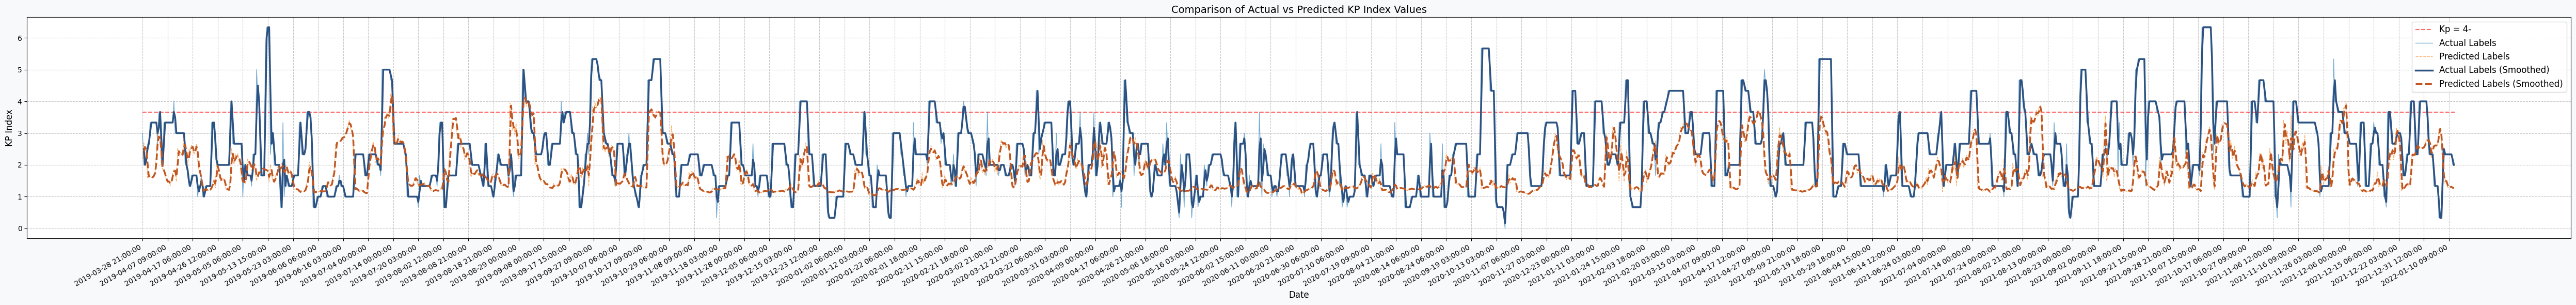

[np.float32(2.1875), np.float32(2.6875), np.float32(2.4375), np.float32(2.5), np.float32(1.59375), np.float32(1.6640625), np.float32(1.65625), np.float32(1.609375), np.float32(1.6015625), np.float32(1.6953125), np.float32(1.7734375), np.float32(2.34375), np.float32(2.96875), np.float32(2.796875), np.float32(2.921875), np.float32(1.984375), np.float32(1.8671875), np.float32(1.8046875), np.float32(1.640625), np.float32(1.5078125), np.float32(1.4453125), np.float32(1.515625), np.float32(1.34375), np.float32(1.515625), np.float32(1.734375), np.float32(1.84375), np.float32(1.7890625), np.float32(1.46875), np.float32(2.53125), np.float32(2.328125), np.float32(2.390625), np.float32(2.359375), np.float32(2.28125), np.float32(2.875), np.float32(2.390625), np.float32(2.421875), np.float32(1.9375), np.float32(2.484375), np.float32(2.4375), np.float32(2.625), np.float32(2.515625), np.float32(2.328125), np.float32(2.484375), np.float32(2.671875), np.float32(2.140625), np.float32(1.8203125), np.floa

Testing Progress:   0%|          | 0/146 [00:00<?, ?it/s]

Average test loss: 4.9763
RMSE: 2.2308
MSE: 4.9848
MAE: 2.0200
R²: -9.9492
R: 0.1838


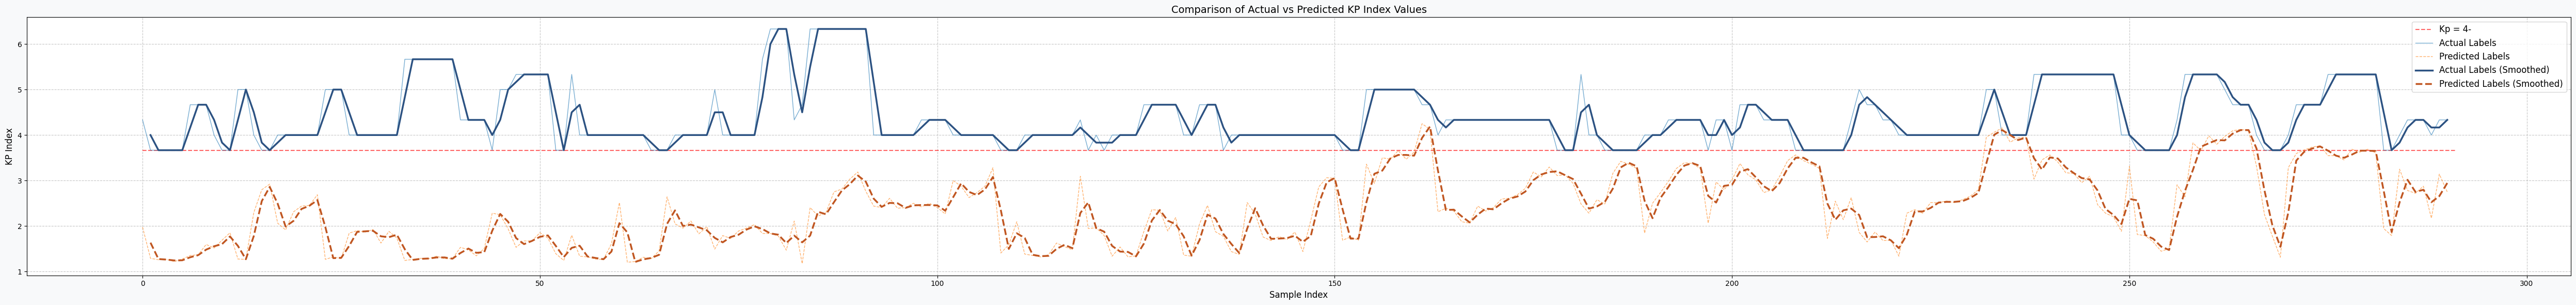

[np.float32(1.9765625), np.float32(1.2890625), np.float32(1.2578125), np.float32(1.265625), np.float32(1.21875), np.float32(1.2734375), np.float32(1.3515625), np.float32(1.3671875), np.float32(1.59375), np.float32(1.515625), np.float32(1.6875), np.float32(1.8515625), np.float32(1.2734375), np.float32(1.265625), np.float32(2.296875), np.float32(2.796875), np.float32(2.921875), np.float32(2.0625), np.float32(1.9140625), np.float32(2.3125), np.float32(2.4375), np.float32(2.453125), np.float32(2.6875), np.float32(1.265625), np.float32(1.3203125), np.float32(1.28125), np.float32(1.84375), np.float32(1.8984375), np.float32(1.8671875), np.float32(1.921875), np.float32(1.625), np.float32(1.8828125), np.float32(1.734375), np.float32(1.2421875), np.float32(1.265625), np.float32(1.2890625), np.float32(1.28125), np.float32(1.3359375), np.float32(1.28125), np.float32(1.28125), np.float32(1.53125), np.float32(1.4765625), np.float32(1.34375), np.float32(1.5078125), np.float32(2.28125), np.float32(2.2

Training Progress: Epoch: 1:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.8403759625723006


Validation Progress: Epoch: 1:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  1.7531524231372815


Training Progress: Epoch: 2:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.3412507044033735


Validation Progress: Epoch: 2:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  1.9057567642191247


Training Progress: Epoch: 3:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  1.01021959806946


Validation Progress: Epoch: 3:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  1.789765789291529


Training Progress: Epoch: 4:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.7528450172246582


Validation Progress: Epoch: 4:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.011818831026642


Training Progress: Epoch: 5:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.5792510510309286


Validation Progress: Epoch: 5:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.1165716142387927


Training Progress: Epoch: 6:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.4807231814682638


Validation Progress: Epoch: 6:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.125519027111583


Training Progress: Epoch: 7:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.39438802037067106


Validation Progress: Epoch: 7:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.400363396689717


Training Progress: Epoch: 8:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.32656707983365485


Validation Progress: Epoch: 8:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.1353237682720474


Training Progress: Epoch: 9:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.2939598935069755


Validation Progress: Epoch: 9:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.196002302086503


Training Progress: Epoch: 10:   0%|          | 0/3702 [00:00<?, ?it/s]

Average Training Loss:  0.24312240809447966


Validation Progress: Epoch: 10:   0%|          | 0/936 [00:00<?, ?it/s]

Average Validation Loss:  2.4528127028165922


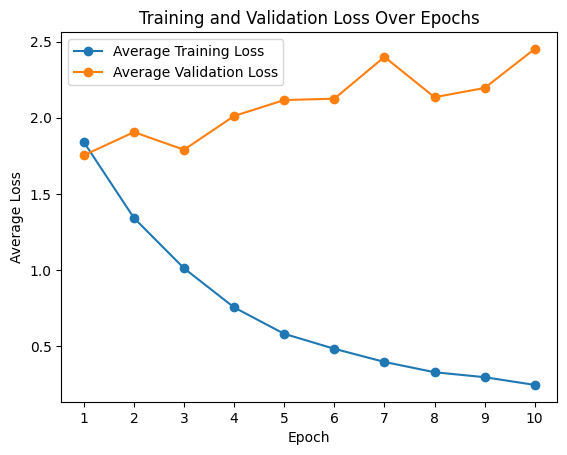

--------------------------------
Test for Full set
--------------------------------


Testing Progress:   0%|          | 0/936 [00:00<?, ?it/s]

Average test loss: 2.4528
RMSE: 1.5661
MSE: 2.4528
MAE: 1.1787
R²: -0.4175
R: 0.1859
True Skill Score: 0.6086
Accuracy: 0.6560
Precision: 0.6446
Recall: 0.1149
F1 Score: 0.1950


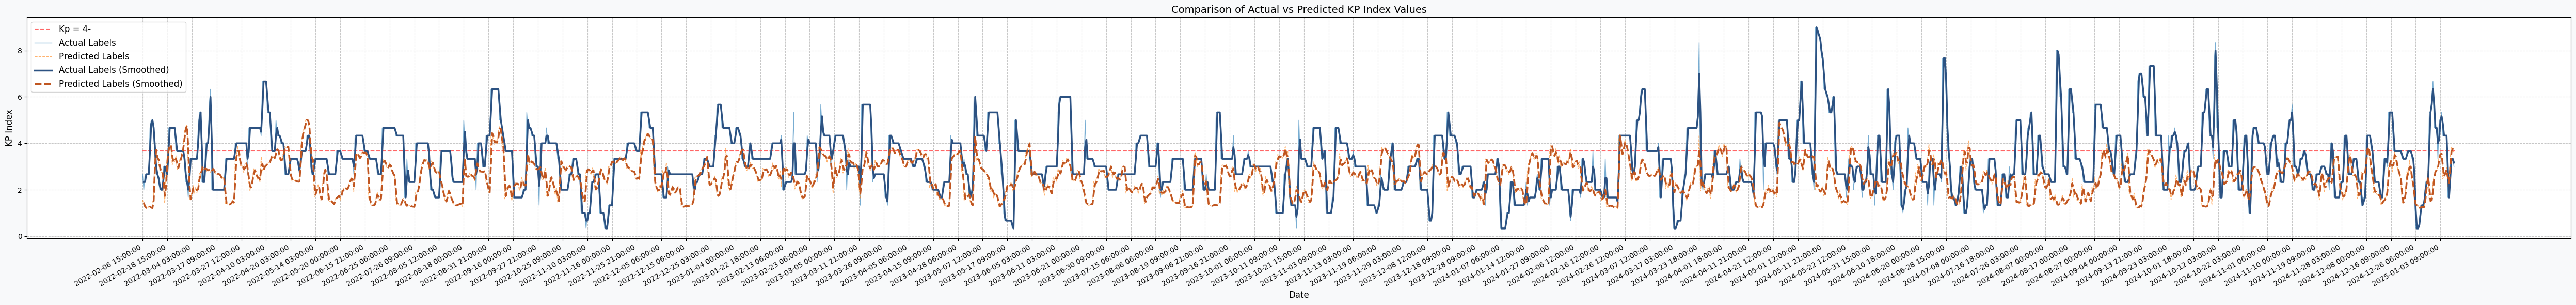

[np.float32(1.5703125), np.float32(1.328125), np.float32(1.234375), np.float32(1.21875), np.float32(1.1875), np.float32(1.2890625), np.float32(1.265625), np.float32(1.203125), np.float32(1.2265625), np.float32(1.84375), np.float32(4.0625), np.float32(3.359375), np.float32(3.421875), np.float32(3.171875), np.float32(2.828125), np.float32(2.75), np.float32(2.765625), np.float32(2.046875), np.float32(1.4140625), np.float32(2.859375), np.float32(3.484375), np.float32(3.828125), np.float32(3.984375), np.float32(3.859375), np.float32(3.078125), np.float32(3.3125), np.float32(3.203125), np.float32(3.46875), np.float32(2.84375), np.float32(3.03125), np.float32(3.296875), np.float32(3.328125), np.float32(3.703125), np.float32(3.875), np.float32(4.5625), np.float32(4.71875), np.float32(4.78125), np.float32(2.796875), np.float32(1.5625), np.float32(1.6171875), np.float32(1.9375), np.float32(2.203125), np.float32(1.8515625), np.float32(2.109375), np.float32(1.875), np.float32(2.15625), np.float32(

Testing Progress:   0%|          | 0/340 [00:00<?, ?it/s]

Average test loss: 5.1372
RMSE: 2.2665
MSE: 5.1445
MAE: 1.8906
R²: -4.6001
R: -0.0581


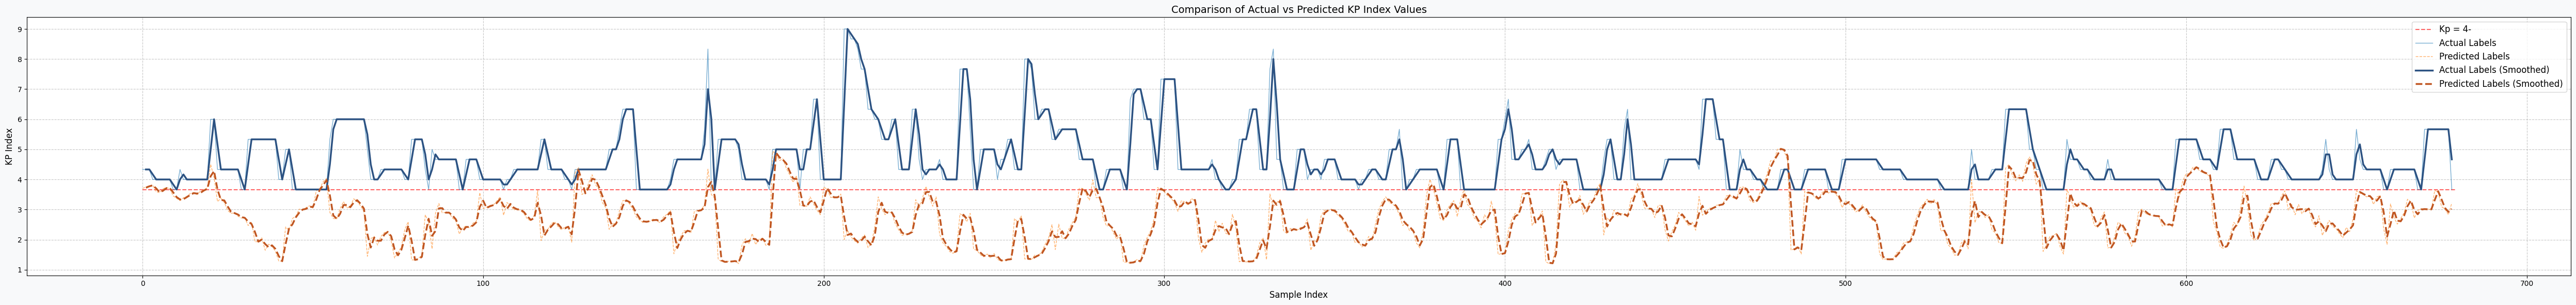

[np.float32(3.703125), np.float32(3.75), np.float32(3.796875), np.float32(3.8125), np.float32(3.59375), np.float32(3.5625), np.float32(3.6875), np.float32(3.734375), np.float32(3.6875), np.float32(3.453125), np.float32(3.375), np.float32(3.296875), np.float32(3.390625), np.float32(3.4375), np.float32(3.53125), np.float32(3.5625), np.float32(3.5), np.float32(3.609375), np.float32(3.65625), np.float32(3.71875), np.float32(4.5), np.float32(4.0625), np.float32(3.265625), np.float32(3.375), np.float32(3.234375), np.float32(2.96875), np.float32(2.875), np.float32(2.890625), np.float32(2.78125), np.float32(2.71875), np.float32(2.734375), np.float32(2.46875), np.float32(2.578125), np.float32(1.9296875), np.float32(1.9375), np.float32(2.0625), np.float32(1.6484375), np.float32(1.8515625), np.float32(1.7734375), np.float32(1.6171875), np.float32(1.2890625), np.float32(1.28125), np.float32(2.421875), np.float32(2.3125), np.float32(2.703125), np.float32(2.78125), np.float32(3.015625), np.float32(2

In [12]:
torch.set_float32_matmul_precision('medium')
fabric = Fabric(accelerator='cuda', devices=1, precision="bf16-mixed")
fabric.launch(train_model)

In [13]:
# prompt: disconnect runtime
import time
time.sleep(5 * 60)
from google.colab import runtime
runtime.unassign()
